In [166]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from typing import Union, Optional, Tuple
from pathlib import Path
import nbimporter
import visualization

In [145]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '_mask.gif'))

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L")) // 255 # Converting mask into binary values

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask


In [ ]:
def get_transforms():
    return A.Compose([
        A.RandomCrop(256, 256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])

5088


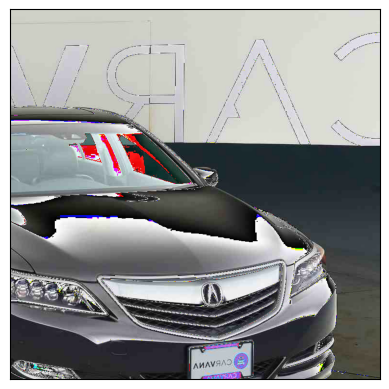

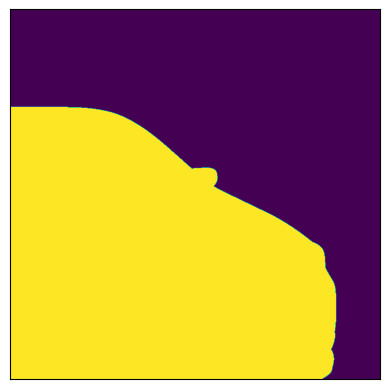

In [147]:
image_dir = 'D:/machine-learning/datasets/carvana/train/train'
mask_dir = 'D:/machine-learning/datasets/carvana/train_masks/train_masks'
transform = get_transforms()
dataset = CarvanaDataset(image_dir, mask_dir, transform)
print(len(dataset))
img, msk = dataset[1]
visualization.show(img)
visualization.show(msk)

In [148]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(self.double_conv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(self.double_conv(feature*2, feature))

        self.bottleneck = self.double_conv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]

            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])

            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)

        return torch.sigmoid(self.final_conv(x))

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )


In [149]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, figsize=(6, 4), fmts=('-', 'm--', 'g-.', 'r:'), ncols=1):
        # Set up figure and axes
        self.fig, self.ax = plt.subplots(figsize=figsize, ncols=ncols)
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.legend = legend
        self.fmts = fmts
        self.xlim = xlim
        self.ylim = ylim
        self.X, self.Y = [], []
        self.configured = False

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        if not hasattr(x, "__len__"):
            x = [x] * len(y)

        if not self.configured:
            self.configured = True
            if self.legend:
                self.ax.legend(self.legend)
            self.ax.set_xlabel(self.xlabel)
            self.ax.set_ylabel(self.ylabel)
            if self.xlim:
                self.ax.set_xlim(self.xlim)
            if self.ylim:
                self.ax.set_ylim(self.ylim)
            self.ax.grid(True)

        for i, (a, b) in enumerate(zip(x, y)):
            if len(self.X) <= i:
                self.X.append([])
                self.Y.append([])
            self.X[i].append(a)
            self.Y[i].append(b)

        self.ax.cla()
        for i, (x_vals, y_vals) in enumerate(zip(self.X, self.Y)):
            self.ax.plot(x_vals, y_vals, self.fmts[i % len(self.fmts)], label=self.legend[i] if self.legend else None)

        if self.legend:
            self.ax.legend(loc='upper right')
        self.ax.set_xlabel(self.xlabel)
        self.ax.set_ylabel(self.ylabel)
        if self.xlim:
            self.ax.set_xlim(self.xlim)
        if self.ylim:
            self.ax.set_ylim(self.ylim)
        self.ax.grid(True)
        display.clear_output(wait=True)
        display.display(self.fig)
    
    def close(self):
        plt.close(self.fig)

In [150]:
def compute_iou_per_class(preds: torch.Tensor, targets: torch.Tensor, num_classes: int = 21, ignore_index: int = 255):
    """
    Computes the per-class Intersection over Union (IoU) for semantic segmentation.

    Args:
        preds (torch.Tensor): Predictions with shape [B, C, H, W].
        targets (torch.Tensor): Ground truth with shape [B, H, W].
        num_classes (int): Number of classes.
        ignore_index (int): Index to ignore in the ground truth mask (e.g., 255 for VOC2012).

    Returns:
        iou_per_class (torch.Tensor): Tensor of shape [num_classes] with IoU for each class.
    """
    # Convert predictions to [B, H, W] by taking argmax over channel dimension
    preds = torch.argmax(preds, dim=1)  # shape: [B, H, W]

    iou_per_class = torch.zeros(num_classes, dtype=torch.float32, device=preds.device)
    eps = 1e-6  # to avoid division by zero

    for cls in range(num_classes):
        pred_mask = (preds == cls)
        target_mask = (targets == cls)

        # If using an ignore index, exclude it from both masks
        if ignore_index is not None:
            valid_mask = (targets != ignore_index)
            pred_mask = pred_mask & valid_mask
            target_mask = target_mask & valid_mask

        intersection = (pred_mask & target_mask).sum().float()
        union = (pred_mask | target_mask).sum().float()

        iou = intersection / (union + eps)
        iou_per_class[cls] = iou

    return iou_per_class

def compute_binary_iou(preds: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5, ignore_index: int = 255):
    """
    Computes the IoU for binary segmentation.

    Args:
        preds (torch.Tensor): Predictions of shape [B, 1, H, W] or [B, H, W] (after sigmoid).
        targets (torch.Tensor): Ground truth of shape [B, 1, H, W] or [B, H, W].
        threshold (float): Threshold for binarizing predictions.
        ignore_index (int): Value to ignore in targets.

    Returns:
        float: IoU score.
    """
    if preds.ndim == 4:
        preds = preds.squeeze(1)
    if targets.ndim == 4:
        targets = targets.squeeze(1)

    preds = (preds >= threshold).to(torch.bool)
    targets = targets.to(torch.bool)

    if ignore_index is not None:
        valid_mask = targets != ignore_index
        preds = preds & valid_mask
        targets = targets & valid_mask

    intersection = (preds & targets).sum(dim=(1, 2))
    union = (preds | targets).sum(dim=(1, 2))

    iou = intersection.float() / (union.float() + 1e-6)
    return iou.mean()  # mean over batch


def IoU_per_class(preds, labels, num_classes, ignore_index=None):
    """
    Compute IoU for each class.

    Args:
        preds (Tensor): [B, H, W] predicted class indices
        labels (Tensor): [B, H, W] ground truth class indices
        num_classes (int): total number of classes
        ignore_index (int, list or tuple of ints or None): class index to ignore (e.g., 255 in VOC)

    Returns:
        ious (Tensor): [num_classes] IoU for each class
    """
    ious = []
    for cls in range(num_classes):
        if ignore_index is not None and cls == ignore_index:
            ious.append(float('nan'))
            continue
        
        print
        pred_inds = (preds == cls)
        target_inds = (labels == cls)

        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            iou = float('nan')  # or 1.0 if you consider empty classes as 100% IoU
        else:
            iou = intersection / union

        ious.append(iou)
    
    return torch.tensor(ious)

def IoU_per_batch(outputs, label, EPSILON = 1e-6):
    print(outputs.shape, label.shape)
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & label).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | label).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + EPSILON) / (union + EPSILON)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded

In [ ]:
def save_prediction(pred_tensor, filename="prediction.png"):
    """
    Save a binary prediction mask (0 and 255) as a proper grayscale image.
    Args:
        preds (Tensor): [1, H, W] prediction image with values between 0 and 255
        filename (Pathlike): destination and file name to save the prediction image
    Returns:
        None
    """
    pred_tensor = pred_tensor.squeeze().detach().cpu()
    pred_array = pred_tensor.numpy().astype(np.uint8)
    img = Image.fromarray(pred_array, mode="L")
    img.save(filename)

def save_predictions(model, loader, device, epoch):
    '''Saves each image and predicted mask pair in a folder for that epoch.'''
    epoch = epoch + 1 if epoch > 0 else epoch
    
    to_pil = transforms.ToPILImage()
    save_dir = f'D:/machine-learning/datasets/carvana/preds/{epoch}/'
    os.makedirs(save_dir, exist_ok=True)
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            if idx == 250:
                break
            x = x.to(device)
            y = y.to(device).unsqueeze(1).float()
            preds = model(x)
            # You can visualize or calculate IoU here

            for i in range(x.size(0)):
                # print(f'x.shape={x[i].shape}, pred.shape={preds[i].shape}')
                x_i = to_pil(x[i].cpu())
                x_i.save(os.path.join(save_dir, f"{idx}_{i}_image.png"))

                # pred_mask = (preds[i] > 0.5).float()
                # pred_mask = (pred_mask * 255).byte().cpu().squeeze(0)
                # pred_pil = to_pil(pred_mask)
                # pred_pil.save(os.path.join(save_dir, f"{idx}_{i}_mask.png"))
                
                pred_i = preds[i]
                pred_i[pred_i >= 0.5] = 255
                pred_i[pred_i < 0.5] = 0
                # to_pil(pred_i).save(os.path.join(save_dir, f"{idx}_{i}_mask.png"))
                save_prediction(pred_i, os.path.join(save_dir, f"{idx}_{i}_mask.png"))

In [152]:
def train_fn(loader, model, optimizer, loss_fn, device):
    model.train()
    for batch_idx, (data, targets) in enumerate(loader):
        # print(f'Batch {batch_idx}')
        data = data.to(device)
        targets = targets.float().unsqueeze(1).to(device)

        preds = model(data)
        loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iou_score = compute_binary_iou(preds, targets)
        # print(f"IoU: {iou_score:.4f}")

    
    return loss, iou_score

In [ ]:
def train_network():
    image_dir = 'D:/machine-learning/datasets/carvana/train/train'
    mask_dir = 'D:/machine-learning/datasets/carvana/train_masks/train_masks'
    transform = get_transforms()
    num_epochs = 30

    dataset = CarvanaDataset(image_dir, mask_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()
    animator = Animator(xlabel='Epoch', ylabel='Loss & IoU', legend=['Loss', 'IoU'], ylim=[0, 1.0])
    
    for epoch in range(num_epochs):
        # print(f"Epoch {epoch+1}/{num_epochs}")
        loss, iou_score = train_fn(loader, model, optimizer, loss_fn, device)
        animator.add(epoch, [loss.item(), iou_score.item()])

        if (epoch + 1) % 5 == 0 or epoch == 0:
            save_predictions(model, loader, device, epoch)
    
    animator.close()
    
    model.eval()
    image = Image.open(os.path.join(image_dir, 'b24fd9084449_16.jpg'))
    image = transform(image=np.array(image.convert("RGB")))['image'].unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(image)
    # print(f"Pred stats:, torch.min(pred)={torch.min(pred)} torch.max(pred)={torch.max(pred)}, pred.shape={pred.shape}")

    visualization.show(image.squeeze(0))

    # pred = (pred >= 0.5).to(torch.uint8) * 255
    pred[pred >= 0.5] = 255
    pred[pred < 0.5] = 0
    # print(torch.unique(pred, return_counts=True))
    visualization.show(pred.squeeze(0))
    
    pred[pred >= 0.5] = 255
    pred[pred < 0.5] = 0
    save_prediction(pred, 'D:/machine-learning/datasets/carvana/preds/prediction.png')

    print(f"Final Training Loss: {loss.item()} | Final IoU: {iou_score.item()}")
    return model, 

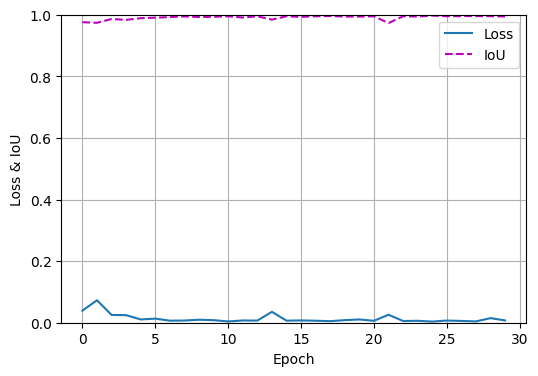

Final Training Loss: 0.00738345505669713 | Final IoU: 0.9943629503250122


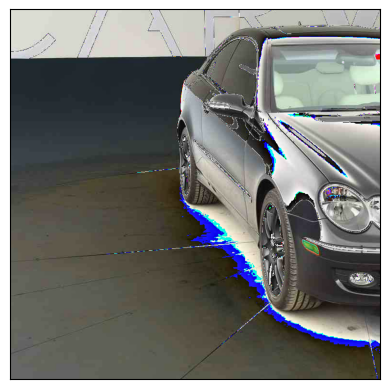

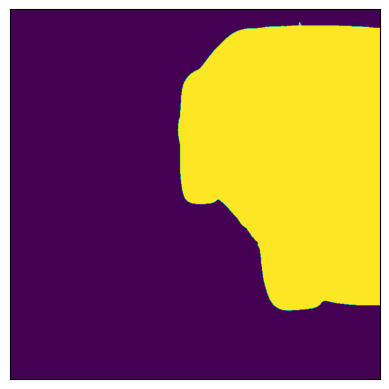

In [154]:
model, loader = train_network()

In [ ]:
def save_checkpoint(
        model: torch.nn.Module,
        checkpoint_dir: Union[str, Path],
        epoch: Optional[int] = None,
        optimizer: Optional[torch.optim.Optimizer] = None,
        loss: Optional[float] = None,
    ):
    """Saves a checkpoint to a file named checkpoint_{epoch}.pth if epoch is given else checkpoint.pth to the checkpoint directory

    Args:
        model (torch.nn.Module): The neural network to ckeckpoint.
        optimizer (torch.optim.Optimizer): The optimizer for the model.
        epoch (int): The last epoch that the model was trained until.
        loss (float): The training loss of the model.
        checkpoint_dir (Union[Pathlike | str]): The directory to save the checkpoint to.
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    file_name =  f"checkpoint_{epoch}.pth" if epoch is not None else "checkpoint.pth"
    checkpoint_path = os.path.join(checkpoint_dir, file_name)

    checkpoint = {
        'model_state_dict': model.state_dict(),
    }
    if optimizer is not None:
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
    if loss is not None:
        checkpoint['loss'] = loss
    if epoch is not None:
        checkpoint['epoch'] = epoch
    
    torch.save(checkpoint, checkpoint_path)


In [165]:
save_checkpoint(model=model, checkpoint_dir=r"D:\machine-learning\datasets\carvana\models", epoch=30)

In [167]:
def load_checkpoint(
    checkpoint_path: Union[str, Path],
    model: torch.nn.Module,
    optimizer: Optional[torch.optim.Optimizer] = None,
    device: Optional[torch.device] = None,
) -> Tuple[int, Optional[float]]:
    """
    Loads a checkpoint from a file and restores model (and optimizer) states.

    Args:
        checkpoint_path (Union[str, Path]): Path to the checkpoint file.
        model (torch.nn.Module): Model to load weights into.
        optimizer (Optional[torch.optim.Optimizer]): Optimizer to load state into (optional).
        device (Optional[torch.device]): Device to map the checkpoint to. 
            Defaults to CPU if not provided.

    Returns:
        epoch (int): The epoch at which the checkpoint was saved, or 0 if not found.
        loss (Optional[float]): The loss stored in checkpoint if available, else None.
    """
    if device is None:
        device = torch.device('cpu')

    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load epoch and loss if present
    epoch = checkpoint.get('epoch', None)
    loss = checkpoint.get('loss', None)

    return epoch, loss

In [169]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint_path = r"D:\machine-learning\datasets\carvana\models\ckeckpoint_30.pth"
model = UNet().to(device)
load_checkpoint(checkpoint_path, model, device=device)

(30, None)